In [1]:
import sys
import pathlib
solitaire_path = pathlib.Path('../')

if solitaire_path not in sys.path:
    sys.path.append(str(solitaire_path))

import os, random, math, json, functools, itertools, base64, importlib, gzip
from tqdm import tqdm

from collections import defaultdict
from datetime import datetime, timedelta, date
from google.protobuf.json_format import MessageToDict
import numpy as np
import pandas as pd
    
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import SGD


import matplotlib.pyplot as plt
    
from solitaire_core.game import *
from solitaire_core import game, text_renderer
from solitaire_ai import vectorization

from auto_play import StatTracker, SingleGamePlayLoop
from auto_play import play_move as play_move_rand


Using TensorFlow backend.


---
# Baseline

In [ ]:
# from auto_play import StatTracker
# from auto_play import play_move as play_move_rand

# TO_EFFECTIVE_WIN = True

# stats = StatTracker(update_interval=5)
# g = deal_game()

# won_game_records = []

# while stats.games_played < 1000:
#     if TO_EFFECTIVE_WIN and g.won_effectively or g.won:
#         stats.mark_won(g.game_record)
#         won_game_records.append(g.game_record)
#         g = deal_game()
#         continue

#     if not play_move_rand(g):
#         stats.mark_lost(g.game_record)
#         g = deal_game()
#         continue

#     assert is_valid_game_state(g.gs), g.get_game_state_id()

#     stats.mark_move()
    
# stats.print_stats()
# print("Done")

---
# Training

In [3]:
# Optionally load from backup file instead of playing to a baseline

won_game_records = []
with gzip.open("../2019-05-31-10-07-25-win-game-records.b64.gz") as f:
    line = f.readline()
    while line:
        gr = GameRecord()
        gr.MergeFromString(base64.b64decode(line))
        won_game_records.append(gr)
        
        line = f.readline()

print(len(won_game_records))

2450


In [ ]:
game_state_vectors = []
action_vectors = []
for gr in tqdm(won_game_records):
    gs = VisibleGameState()
    hgs = HiddenGameState()

    gs.MergeFrom(gr.initial_state)
    hgs.MergeFrom(gr.initial_hidden_state)

    # Replay all the actions:
    for a in gr.actions:
        game_state_vectors.append(vectorization.game_state_to_array(gs))
        action_vectors.append(vectorization.action_to_onehot(a))

        res = game._try_apply_action(gs, hgs, a)
        assert is_valid_game_state(gs)

        if not res:
            raise Exception()

assert len(game_state_vectors) == len(action_vectors)
assert all(len(gs) == len(game_state_vectors[0]) for gs in game_state_vectors)
assert all(len(a) == len(action_vectors[0]) for a in action_vectors)

print(len(game_state_vectors))
print("Done")

In [4]:
# This and stuff below kind of taken from https://www.pyimagesearch.com/2018/09/10/keras-tutorial-how-to-get-started-with-keras-deep-learning-and-python/

data = np.array(game_state_vectors, dtype="float")
labels = np.array(action_vectors)

(train_x, test_x, train_y, test_y) = train_test_split(data, labels, test_size=0.25)

In [6]:
model = Sequential()
model.add(Dense(512, input_shape=(len(game_state_vectors[0]),), activation="relu"))
# model.add(Dropout(0.25))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.1))
# model.add(Dense(128, activation="relu"))
# model.add(Dropout(0.1))
model.add(Dense(len(action_vectors[0]), activation="softmax"))

# initialize our initial learning rate and # of epochs to train for
INIT_LR = 0.01
EPOCHS = 50

print("Train training network...")
opt = SGD(lr=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the neural network
H = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=EPOCHS, batch_size=32)

print("Done")

22011/22011 [==============================] - 2s 108us/step - loss: 3.0821 - acc: 0.2614 - val_loss: 3.7546 - val_acc: 0.1427
Epoch 46/50
22011/22011 [==============================] - 2s 105us/step - loss: 3.0546 - acc: 0.2674 - val_loss: 3.7510 - val_acc: 0.1442
Epoch 47/50
22011/22011 [==============================] - 2s 102us/step - loss: 3.0357 - acc: 0.2717 - val_loss: 3.7608 - val_acc: 0.1405
Epoch 48/50
22011/22011 [==============================] - 2s 102us/step - loss: 3.0126 - acc: 0.2744 - val_loss: 3.7634 - val_acc: 0.1443
Epoch 49/50
22011/22011 [==============================] - 2s 96us/step - loss: 2.9827 - acc: 0.2816 - val_loss: 3.7558 - val_acc: 0.1451
Epoch 50/50
22011/22011 [==============================] - 2s 98us/step - loss: 2.9688 - acc: 0.2812 - val_loss: 3.7613 - val_acc: 0.1475
Done


In [ ]:
model = Sequential()
model.add(Dense(128, input_shape=(len(game_state_vectors[0]),), activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(len(action_vectors[0]), activation="softmax"))

# initialize our initial learning rate and # of epochs to train for
INIT_LR = 0.01
EPOCHS = 50

print("Train training network...")
opt = SGD(lr=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the neural network
H = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=EPOCHS, batch_size=32)

print("Done")

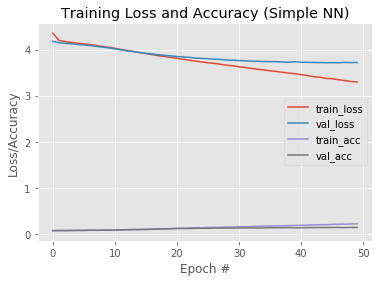

In [22]:
# evaluate the network
# print("[INFO] evaluating network...")
# predictions = model.predict(test_x, batch_size=32)
# print(classification_report(test_y.argmax(axis=1), predictions.argmax(axis=1)))
 
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

---
# Now play


In [10]:
stats = StatTracker(update_interval=5)
g = deal_game()

TO_EFFECTIVE_WIN = True
won_game_records_w_model = []

while stats.games_played < 200:
    if TO_EFFECTIVE_WIN and g.won_effectively or g.won:
        stats.mark_won()
        won_game_records_w_model.append(g.game_record)
        g = deal_game()
        continue
    
    valid_actions = g.get_valid_actions()
    if not valid_actions:
        stats.mark_lost()
        g = deal_game()
        continue
    
    prediction = model.predict(np.array([vectorization.game_state_to_array(g.gs)]))
    action = vectorization.onehot_to_action(prediction[0], valid_actions)
    
    g.apply_action(action)

    assert is_valid_game_state(g.gs), g.get_game_state_id()

    stats.mark_move()
    
stats.print_stats()
print("Done")

Name:                	Played:     8  	Won:    2  	Lost:    6  	Total moves:   1902  	moves/s: 380.38  	 Win rate:  0.25  	
Name:                	Played:    23  	Won:    5  	Lost:   18  	Total moves:   3868  	moves/s: 393.04  	 Win rate:  0.22  	
Name:                	Played:    34  	Won:    9  	Lost:   25  	Total moves:   5780  	moves/s: 382.29  	 Win rate:  0.26  	
Name:                	Played:    44  	Won:   12  	Lost:   32  	Total moves:   7656  	moves/s: 375.04  	 Win rate:  0.27  	
Name:                	Played:    58  	Won:   14  	Lost:   44  	Total moves:   9592  	moves/s: 387.17  	 Win rate:  0.24  	
Name:                	Played:    66  	Won:   19  	Lost:   47  	Total moves:  11490  	moves/s: 379.51  	 Win rate:  0.29  	
Name:                	Played:    75  	Won:   21  	Lost:   54  	Total moves:  13399  	moves/s: 381.71  	 Win rate:  0.28  	
Name:                	Played:    82  	Won:   23  	Lost:   59  	Total moves:  15280  	moves/s: 376.02  	 Win rate:  0.28  	
Name:           